## Setting up the environment

To install the packages necessary to run this release notebook, run the following in the terminal. You will need to first access this folder using the terminal. 


conda create -n plso python=3.9

conda activate plso

pip install -r requirements.txt


You will need to run conda activate plso in the terminal before each time you launch this jupyter notebook. 

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer
from torch.utils.data import WeightedRandomSampler 
import torch.nn as nn
from transformers import BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch.nn.functional as F
import time

import calibration_fns as cal

from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score, roc_auc_score

In [2]:
cwd = os.getcwd()
data_folder = cwd + '/Prepared_data/'

### Step 1. Set up dataset for pytorch

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
data_sources = pd.read_excel(data_folder + 'data_sources.xlsx')
data_more = pd.read_excel(data_folder + 'data_more.xlsx')
data_better = pd.read_excel(data_folder + 'data_better.xlsx')
data_classical = pd.read_excel(data_folder + 'data_classical.xlsx')
data_quantum = pd.read_excel(data_folder + 'data_quantum.xlsx')

In [5]:
num_examples = pd.DataFrame({"code": ["P","L","S","O"],
              "sources": [data_sources["P"].value_counts()[1], data_sources["L"].value_counts()[1], data_sources["S"].value_counts()[1], data_sources["O"].value_counts()[1]],
              "more": [data_more["P"].value_counts()[1], data_more["L"].value_counts()[1], data_more["S"].value_counts()[1], data_more["O"].value_counts()[1]],
              "better": [data_better["P"].value_counts()[1], data_better["L"].value_counts()[1], data_better["S"].value_counts()[1], data_better["O"].value_counts()[1]],
              "classical": [data_classical["P"].value_counts()[1], data_classical["L"].value_counts()[1], data_classical["S"].value_counts()[1], data_classical["O"].value_counts()[1]],
              "quantum": [data_quantum["P"].value_counts()[1], data_quantum["L"].value_counts()[1], data_quantum["S"].value_counts()[1], data_quantum["O"].value_counts()[1]]
             })
num_examples['sum'] = num_examples[['sources', 'more', 'better','classical','quantum']].sum(axis=1)

In [6]:
num_examples

#1. Validation and test sets must be obtained independently, come from the same distribution (training set may be different), that looks as much as possible like the data you expect to observe once deployed in production.
#2. To get decent statistics, validation and test sets must have a few dozen examples of each class


,code,sources,more,better,classical,quantum,sum
0,P,160,23,44,4,108,339
1,L,2212,91,279,103,28,2713
2,S,117,255,36,4,2,414
3,O,410,43,52,58,53,616


What data do we need to reserve for validation and testing? What can we use for training?

1. Validation and test sets must be obtained independently, come from the same distribution (training set may be different), that looks as much as possible like the data you expect to observe once deployed in production.
2. To get decent statistics, validation and test sets must have a few dozen examples of each class


To keep the distribution for validation and test sets as close as possible to the data we expect to observe in production, we will take clean percentages of the full data set when splitting data between training and validation and test. 

Can combine more/better and classical/quantum for validation and testing, out of necessity and because the same coding scheme is applied. 


There is no way we can validate a model to detect S in classical/quantum because it simply does not happen frequently enough. 

For sources, if we want to be able to validate for P and L we need at least 20% of the data. This will leave us with about 32 examples of P and 24 examples of S. So we will put 60% of the sources data into training.

For more/better, if we want semi-decent statistics on P and O we need at least 30%. This will leave us with about 20 examples of P and about 28 examples of O. So we will put 40% of the more better data into training.

For generic (classical/quantum), we need at least 20% of the data. That will give us about 22 examples for P, 26 examples for L, and 22 examples for O. S does not happen frequently enough and cannot be tested. 

In [7]:
data_sources["Question"] = "Sources"
data_more["Question"] = "More"
data_better["Question"] = "Better"
data_classical["Question"] = "Classical"
data_quantum["Question"] = "Quantum"

#shuffle data
data_sources = data_sources.sample(frac=1).reset_index(drop=True)
data_more = data_more.sample(frac=1).reset_index(drop=True)
data_better = data_better.sample(frac=1).reset_index(drop=True)
data_classical = data_classical.sample(frac=1).reset_index(drop=True)
data_quantum = data_quantum.sample(frac=1).reset_index(drop=True)

#split data by question
def split_data(dat, test_percent = 0.10, val_percent = 0.10, train_percent = 0.80):
    test_size = int(test_percent*len(dat))
    val_size = int(val_percent*len(dat))
    train_size = int(train_percent*len(dat))
    
    test_data = dat[:test_size]
    val_data = dat[test_size:test_size + val_size]
    train_data = dat[test_size + val_size:]

    return test_data, val_data, train_data

(test_sources, val_sources, train_sources) = split_data(data_sources, test_percent = 0.2, val_percent = 0.2, train_percent = 0.6)
(test_more, val_more, train_more) = split_data(data_more, test_percent = 0.3, val_percent = 0.3, train_percent = 0.4)
(test_better, val_better, train_better) = split_data(data_better, test_percent = 0.3, val_percent = 0.3, train_percent = 0.4)
(test_classical, val_classical, train_classical) = split_data(data_classical, test_percent = 0.2, val_percent = 0.2, train_percent = 0.6)
(test_quantum, val_quantum, train_quantum) = split_data(data_quantum, test_percent = 0.2, val_percent = 0.2, train_percent = 0.6)

test_data_sources = test_sources[['ResponseId', 'Experiment', 'Question','Input', 'P', 'L', 'S', 'O']]
test_data_morebetter = pd.concat([test_more, test_better])[['ResponseId', 'Experiment', 'Question','Input', 'P', 'L', 'S', 'O']]
test_data_generic = pd.concat([test_classical, test_quantum])[['ResponseId', 'Question','Input', 'P', 'L', 'S', 'O']]

val_data_sources = val_sources[['ResponseId', 'Experiment', 'Question','Input', 'P', 'L', 'S', 'O']]
val_data_morebetter = pd.concat([val_more, val_better])[['ResponseId', 'Experiment', 'Question','Input', 'P', 'L', 'S', 'O']]
val_data_generic = pd.concat([val_classical, val_quantum])[['ResponseId', 'Question','Input', 'P', 'L', 'S', 'O']]

train_data = pd.concat([train_sources, train_more, train_better, train_classical, train_quantum])[['ResponseId', 'Experiment', 'Question','Input', 'P', 'L', 'S', 'O']]

In [8]:
print("Test sets")
print("Sources")
print(test_data_sources[["P","L","S","O"]].sum())
print("More Better")
print(test_data_morebetter[["P","L","S","O"]].sum())
print("Generic")
print(test_data_generic[["P","L","S","O"]].sum())

print("\nValidation sets")
print("Sources")
print(val_data_sources[["P","L","S","O"]].sum())
print("More Better")
print(val_data_morebetter[["P","L","S","O"]].sum())
print("Generic")
print(val_data_generic[["P","L","S","O"]].sum())


Test sets
Sources
P     28
L    441
S     24
O     86
dtype: int64
More Better
P     18
L    116
S     80
O     27
dtype: int64
Generic
P    25
L    28
S     1
O    19
dtype: int64

Validation sets
Sources
P     32
L    442
S     26
O     79
dtype: int64
More Better
P     24
L    105
S     86
O     30
dtype: int64
Generic
P    17
L    24
S     1
O    25
dtype: int64


In [9]:
print(len(train_data))
print(len(val_data_sources))
print(len(val_data_morebetter))
print(len(val_data_generic))
print(len(test_data_sources))
print(len(test_data_morebetter))
print(len(test_data_generic))

2229
579
233
57
579
233
57


In [10]:
def get_max_len(tokenizer, train):
    all_sent = np.array(train.Input.values)
    # Encode data
    encoded_sentences = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_sent]
    # Find the maximum length
    max_len = max([len(sent) for sent in encoded_sentences])
    return max_len

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
MAX_LEN = get_max_len(tokenizer, train_data) 

In [12]:
print(MAX_LEN)

113


In [13]:
def text_preprocessing_simple(text):
    try:
        text = re.sub(r'\s+', ' ', text).strip()
    except:
        pass
    return text

In [14]:
def preprocessing_for_bert(data, tokenizer, max_len):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing_simple(str(sent)),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=max_len,                  # Max length to truncate/pad
            padding='max_length',         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True,      # Return attention mask
            truncation = True)
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [15]:
class Dataset(Dataset):
    def __init__(self, df, tokenizer, max_len, code):
        self.data, self.masks = preprocessing_for_bert(df["Input"], tokenizer, MAX_LEN)
        self.texts = df["Input"].reset_index(drop=True)
        self.labels = torch.tensor(list(df[code]), dtype = torch.long)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        sample = self.data[idx]
        mask = self.masks[idx]
        text = self.texts[idx]
        label = self.labels[idx]
        return sample, mask, text, label

In [16]:
train_dataset_P = Dataset(train_data, tokenizer, MAX_LEN, "P")
val_dataset_sources_P = Dataset(val_data_sources, tokenizer, MAX_LEN,"P")
val_dataset_morebetter_P = Dataset(val_data_morebetter, tokenizer, MAX_LEN,"P")
val_dataset_generic_P = Dataset(val_data_generic, tokenizer, MAX_LEN,"P")
test_dataset_sources_P = Dataset(test_data_sources, tokenizer, MAX_LEN,"P")
test_dataset_morebetter_P = Dataset(test_data_morebetter, tokenizer, MAX_LEN,"P")
test_dataset_generic_P = Dataset(test_data_generic, tokenizer, MAX_LEN,"P")

train_dataset_L = Dataset(train_data, tokenizer, MAX_LEN, "L")
val_dataset_sources_L = Dataset(val_data_sources, tokenizer, MAX_LEN,"L")
val_dataset_morebetter_L = Dataset(val_data_morebetter, tokenizer, MAX_LEN,"L")
val_dataset_generic_L = Dataset(val_data_generic, tokenizer, MAX_LEN,"L")
test_dataset_sources_L = Dataset(test_data_sources, tokenizer, MAX_LEN,"L")
test_dataset_morebetter_L = Dataset(test_data_morebetter, tokenizer, MAX_LEN,"L")
test_dataset_generic_L = Dataset(test_data_generic, tokenizer, MAX_LEN,"L")

train_dataset_S = Dataset(train_data, tokenizer, MAX_LEN, "S")
val_dataset_sources_S = Dataset(val_data_sources, tokenizer, MAX_LEN,"S")
val_dataset_morebetter_S = Dataset(val_data_morebetter, tokenizer, MAX_LEN,"S")
val_dataset_generic_S = Dataset(val_data_generic, tokenizer, MAX_LEN,"S")
test_dataset_sources_S = Dataset(test_data_sources, tokenizer, MAX_LEN,"S")
test_dataset_morebetter_S = Dataset(test_data_morebetter, tokenizer, MAX_LEN,"S")
test_dataset_generic_S = Dataset(test_data_generic, tokenizer, MAX_LEN,"S")

train_dataset_O = Dataset(train_data, tokenizer, MAX_LEN, "O")
val_dataset_sources_O = Dataset(val_data_sources, tokenizer, MAX_LEN,"O")
val_dataset_morebetter_O = Dataset(val_data_morebetter, tokenizer, MAX_LEN,"O")
val_dataset_generic_O = Dataset(val_data_generic, tokenizer, MAX_LEN,"O")
test_dataset_sources_O = Dataset(test_data_sources, tokenizer, MAX_LEN,"O")
test_dataset_morebetter_O = Dataset(test_data_morebetter, tokenizer, MAX_LEN,"O")
test_dataset_generic_O = Dataset(test_data_generic, tokenizer, MAX_LEN,"O")

In [17]:
len(train_dataset_P)

2229

In [18]:
train_dataset_P[2]

(tensor([  101,  2493,  2089,  5245,  1996,  3608,  2830,  2091,  1996, 13276,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 

In [19]:
for data, mask, text, label in train_dataset_P:
    break

In [20]:
class_counts_P = train_data.P.value_counts()
class_counts_L = train_data.L.value_counts()
class_counts_S = train_data.S.value_counts()
class_counts_O = train_data.O.value_counts()

In [21]:
#sample_weights = [1.0 / class_counts[i] for i in train_data.code.values]
class_weights_P = 1.0 / class_counts_P
class_weights_L = 1.0 / class_counts_L
class_weights_S = 1.0 / class_counts_S
class_weights_O = 1.0 / class_counts_O
#class_weights[1] = class_weights[1] / 4 # underweight "other"
sample_weights_P = [class_weights_P[i] for i in train_data.P.values]
sample_weights_L = [class_weights_L[i] for i in train_data.L.values]
sample_weights_S = [class_weights_S[i] for i in train_data.S.values]
sample_weights_O = [class_weights_O[i] for i in train_data.O.values]
class_weights_P = torch.tensor(class_weights_P, dtype=torch.float)
class_weights_L = torch.tensor(class_weights_L, dtype=torch.float)
class_weights_S = torch.tensor(class_weights_S, dtype=torch.float)
class_weights_O = torch.tensor(class_weights_O, dtype=torch.float)

train_sampler_P = WeightedRandomSampler(sample_weights_P,len(train_dataset_P), replacement=True)
train_sampler_L = WeightedRandomSampler(sample_weights_L,len(train_dataset_L), replacement=True)
train_sampler_S = WeightedRandomSampler(sample_weights_S,len(train_dataset_S), replacement=True)
train_sampler_O = WeightedRandomSampler(sample_weights_O,len(train_dataset_O), replacement=True)

train_dataloader_P = DataLoader(train_dataset_P, batch_size = 16, sampler = train_sampler_P)
val_dataloader_sources_P = DataLoader(val_dataset_sources_P, batch_size = 16) 
val_dataloader_morebetter_P = DataLoader(val_dataset_morebetter_P, batch_size = 16) 
val_dataloader_generic_P = DataLoader(val_dataset_generic_P, batch_size = 16) 
test_dataloader_sources_P = DataLoader(test_dataset_sources_P, batch_size = 16) 
test_dataloader_morebetter_P = DataLoader(test_dataset_morebetter_P, batch_size = 16) 
test_dataloader_generic_P = DataLoader(test_dataset_generic_P, batch_size = 16) 

train_dataloader_L = DataLoader(train_dataset_L, batch_size = 16, sampler = train_sampler_L)
val_dataloader_sources_L = DataLoader(val_dataset_sources_L, batch_size = 16) 
val_dataloader_morebetter_L = DataLoader(val_dataset_morebetter_L, batch_size = 16) 
val_dataloader_generic_L = DataLoader(val_dataset_generic_L, batch_size = 16) 
test_dataloader_sources_L = DataLoader(test_dataset_sources_L, batch_size = 16) 
test_dataloader_morebetter_L = DataLoader(test_dataset_morebetter_L, batch_size = 16) 
test_dataloader_generic_L = DataLoader(test_dataset_generic_L, batch_size = 16) 

train_dataloader_S = DataLoader(train_dataset_S, batch_size = 16, sampler = train_sampler_S)
val_dataloader_sources_S = DataLoader(val_dataset_sources_S, batch_size = 16) 
val_dataloader_morebetter_S = DataLoader(val_dataset_morebetter_S, batch_size = 16) 
val_dataloader_generic_S = DataLoader(val_dataset_generic_S, batch_size = 16) 
test_dataloader_sources_S = DataLoader(test_dataset_sources_S, batch_size = 16) 
test_dataloader_morebetter_S = DataLoader(test_dataset_morebetter_S, batch_size = 16)
test_dataloader_generic_S = DataLoader(test_dataset_generic_S, batch_size = 16)

train_dataloader_O = DataLoader(train_dataset_O, batch_size = 16, sampler = train_sampler_O)
val_dataloader_sources_O = DataLoader(val_dataset_sources_O, batch_size = 16) 
val_dataloader_morebetter_O = DataLoader(val_dataset_morebetter_O, batch_size = 16) 
val_dataloader_generic_O = DataLoader(val_dataset_generic_O, batch_size = 16) 
test_dataloader_sources_O = DataLoader(test_dataset_sources_O, batch_size = 16) 
test_dataloader_morebetter_O = DataLoader(test_dataset_morebetter_O, batch_size = 16) 
test_dataloader_generic_O = DataLoader(test_dataset_generic_O, batch_size = 16) 

In [22]:
for sents, masks, texts, labels in train_dataloader_P:
    break

In [23]:
print(sents.shape)
print(masks.shape)
print(labels.shape)

torch.Size([16, 113])
torch.Size([16, 113])
torch.Size([16])


### Step 2. Set up Pytorch Model

In [24]:
class Classifier(nn.Module):
    def __init__(self, num_classes=2, freeze_bert = False):
        #Where we define all the parts of the model
        super(Classifier, self).__init__()  # initialize object with everything from the parent class
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 200, num_classes
        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )
        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
    def forward(self, input_ids, attention_mask):
        # Connect these parts and return the output
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]
        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)
        return logits

Test that an example model takes inputs

In [25]:
model_P = Classifier(num_classes = 2)
print(model_P)

Classifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [26]:
example_out = model_P(sents, masks)

In [27]:
example_out.shape #batch size, num_classes

torch.Size([16, 2])

In [28]:
example_out

tensor([[ 0.2564,  0.0800],
        [ 0.2855,  0.1307],
        [ 0.1811,  0.0334],
        [ 0.1863,  0.0271],
        [ 0.2661,  0.0516],
        [ 0.1652,  0.1735],
        [ 0.1766,  0.0649],
        [ 0.2048,  0.0929],
        [ 0.2699,  0.0588],
        [ 0.1652,  0.1735],
        [ 0.1275, -0.0216],
        [ 0.1945, -0.0311],
        [ 0.1729,  0.0884],
        [ 0.3597,  0.1196],
        [ 0.2260, -0.0492],
        [ 0.2080,  0.0035]], grad_fn=<AddmmBackward0>)

### Step 3. The training loop

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available()  else "cpu")
print(device)

cuda:0


In [30]:
# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights_P)

In [31]:
criterion(example_out, labels) # check that the loss function calculates. It won't be any good yet because we haven't done training

tensor(0.7697, grad_fn=<NllLossBackward0>)

In [32]:
labels

tensor([0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1])

In [33]:
#for param in model_P.bert.pooler.parameters():
#    param.requires_grad = True

#for module in model_P.modules():
#    if isinstance(module, torch.nn.LayerNorm):
#        module.eval()  # Set LayerNorm to eval mode

In [34]:
def training_loop(train_dataloader, val_dataloader1, val_dataloader2, val_dataloader3, class_weights, num_epochs = 5, lr = 1e-5, weight_decay = 1e-5):
    
    num_epochs = 7
    train_losses, val_losses1, val_losses2, val_losses3 = [], [], [], []
    
    model = Classifier(num_classes=2)
    model.to(device)
    
    total_steps = len(train_dataloader) * num_epochs # Total number of training steps
    
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
    
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=0, # Default value
                                                    num_training_steps=total_steps)
    
    loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
    
    
    for epoch in range(num_epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        running_loss = 0.0
        t0_epoch, t0_batch = time.time(), time.time()
        total_loss, batch_loss, batch_counts = 0, 0, 0 # Reset tracking variables at the beginning of each epoch
        model.train() # Set the model to train
        for batch_idx, (sents, masks, texts, labels) in enumerate(train_dataloader): 
            batch_counts +=1
            sents, masks, labels = sents.to(device), masks.to(device), labels.to(device)
            optimizer.zero_grad() # set our optimizer to zero_grad
            outputs = model(sents, masks) # get our outputs by calling the forward method on the images
            loss = loss_fn(outputs, labels)
            loss.backward() # this is where we do backpropagation on the model to update the model weights
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
            optimizer.step()
            scheduler.step()
            #print(f"Batch {batch_idx}: Loss = {loss.item()}")
            batch_loss += loss.item()
            running_loss += loss.item() * sents.size(0)
            # Print the loss values and time elapsed for every 20 batches
            if (batch_idx % 20 == 0 and batch_idx != 0) or (batch_idx == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                # Print training results
                print(f"{epoch + 1:^7} | {batch_idx:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")
        batch_loss, batch_counts = 0, 0
        t0_batch = time.time()
        train_loss = running_loss / len(train_dataloader.dataset)
        train_losses.append(train_loss)
        print("-"*70)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        val_accuracy1 = []
        with torch.no_grad(): #to make sure the model weights are not touched
            for sents, masks, texts, labels in val_dataloader1:
                sents, masks, labels = sents.to(device), masks.to(device), labels.to(device)
                outputs = model(sents, masks)
                loss = loss_fn(outputs, labels)
                running_loss += loss.item() * sents.size(0)
                # Get the predictions
                preds = torch.argmax(outputs, dim=1).flatten()
                # Calculate the accuracy rate
                accuracy = (preds == labels).cpu().numpy().mean() * 100
                val_accuracy1.append(accuracy)
                time_elapsed = time.time() - t0_epoch
        val_loss1 = running_loss / len(val_dataloader1.dataset)
        val_losses1.append(val_loss1)
        val_accuracy1 = np.mean(val_accuracy1)
    
        #Print epoch stats
        print(f"{'Epoch':^7} | {'Dataset':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        print(f"{epoch+1:^7} | {'Sources':^7} | {train_loss:^12.6f} | {val_loss1:^10.6f} | {val_accuracy1:^9.2f} | {time_elapsed:^9.2f}")
        
        running_loss = 0.0
        val_accuracy2 = []
        with torch.no_grad(): #to make sure the model weights are not touched
            for sents, masks, texts, labels in val_dataloader2:
                sents, masks, labels = sents.to(device), masks.to(device), labels.to(device)
                outputs = model(sents, masks)
                loss = loss_fn(outputs, labels)
                running_loss += loss.item() * sents.size(0)
                # Get the predictions
                preds = torch.argmax(outputs, dim=1).flatten()
                # Calculate the accuracy rate
                accuracy = (preds == labels).cpu().numpy().mean() * 100
                val_accuracy2.append(accuracy)
                time_elapsed = time.time() - t0_epoch
        val_loss2 = running_loss / len(val_dataloader2.dataset)
        val_losses2.append(val_loss2)
        val_accuracy2 = np.mean(val_accuracy2)
    
        #Print epoch stats
        print(f"{epoch+1:^7} | {'MB':^7} | {train_loss:^12.6f} | {val_loss2:^10.6f} | {val_accuracy2:^9.2f} | {time_elapsed:^9.2f}")

        running_loss = 0.0
        val_accuracy3 = []
        with torch.no_grad(): #to make sure the model weights are not touched
            for sents, masks, texts, labels in val_dataloader3:
                sents, masks, labels = sents.to(device), masks.to(device), labels.to(device)
                outputs = model(sents, masks)
                loss = loss_fn(outputs, labels)
                running_loss += loss.item() * sents.size(0)
                # Get the predictions
                preds = torch.argmax(outputs, dim=1).flatten()
                # Calculate the accuracy rate
                accuracy = (preds == labels).cpu().numpy().mean() * 100
                val_accuracy3.append(accuracy)
                time_elapsed = time.time() - t0_epoch
        val_loss3 = running_loss / len(val_dataloader3.dataset)
        val_losses3.append(val_loss3)
        val_accuracy3 = np.mean(val_accuracy3)
    
        #Print epoch stats
        print(f"{epoch+1:^7} | {'Generic':^7} | {train_loss:^12.6f} | {val_loss3:^10.6f} | {val_accuracy3:^9.2f} | {time_elapsed:^9.2f}")

    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses1, label='Validation loss 1')
    plt.plot(val_losses2, label='Validation loss 2')
    plt.plot(val_losses3, label='Validation loss 3')
    plt.legend()
    plt.title("Loss over epochs")
    plt.show()

    return model

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.417668   |     -      |     -     |   3.02   
   1    |   40    |   0.341299   |     -      |     -     |   4.66   
   1    |   60    |   0.290506   |     -      |     -     |   6.30   
   1    |   80    |   0.247788   |     -      |     -     |   7.95   
   1    |   100   |   0.218084   |     -      |     -     |   9.59   
   1    |   120   |   0.201616   |     -      |     -     |   11.24  
   1    |   139   |   0.182656   |     -      |     -     |   12.79  
----------------------------------------------------------------------
 Epoch  | Dataset |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    | Sources |   0.183362   |  0.238695  |   92.74   |   13.68  
   1    |   MB    |   0.183362   |  0.481169  |   77.18   |   14.05  
   1    | Generic

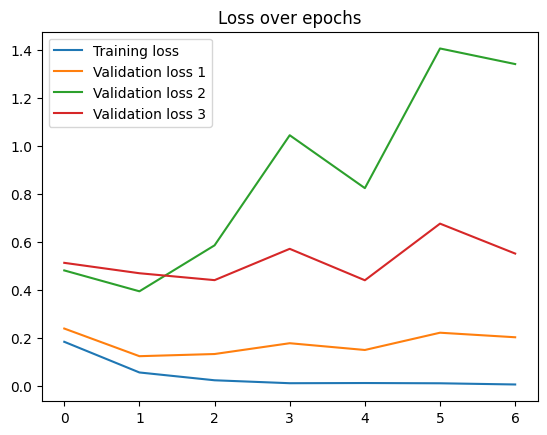

In [35]:
#run training loop for "P"
model_P = training_loop(train_dataloader_P, val_dataloader_sources_P, val_dataloader_morebetter_P, val_dataloader_generic_P, class_weights_P)

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.632092   |     -      |     -     |   1.75   
   1    |   40    |   0.587011   |     -      |     -     |   3.41   
   1    |   60    |   0.546401   |     -      |     -     |   5.07   
   1    |   80    |   0.506074   |     -      |     -     |   6.74   
   1    |   100   |   0.479026   |     -      |     -     |   8.41   
   1    |   120   |   0.458075   |     -      |     -     |   10.07  
   1    |   139   |   0.430367   |     -      |     -     |   11.62  
----------------------------------------------------------------------
 Epoch  | Dataset |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    | Sources |   0.431928   |  0.297245  |   86.60   |   12.51  
   1    |   MB    |   0.431928   |  0.763705  |   70.69   |   12.88  
   1    | Generic

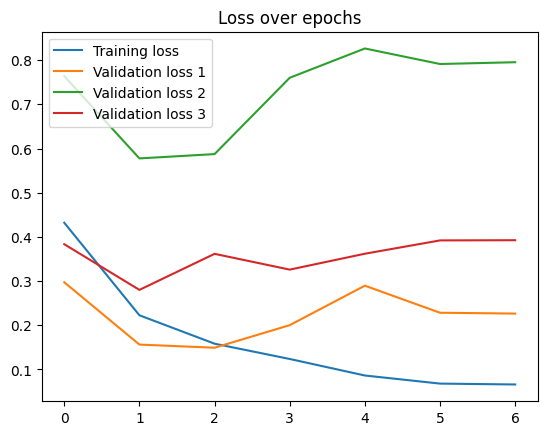

In [36]:
#run training loop for "L"
model_L = training_loop(train_dataloader_L, val_dataloader_sources_L, val_dataloader_morebetter_L, val_dataloader_generic_L, class_weights_L)

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.498326   |     -      |     -     |   1.78   
   1    |   40    |   0.382453   |     -      |     -     |   3.45   
   1    |   60    |   0.316783   |     -      |     -     |   5.13   
   1    |   80    |   0.282962   |     -      |     -     |   6.80   
   1    |   100   |   0.247584   |     -      |     -     |   8.48   
   1    |   120   |   0.222095   |     -      |     -     |   10.16  
   1    |   139   |   0.202690   |     -      |     -     |   11.72  
----------------------------------------------------------------------
 Epoch  | Dataset |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    | Sources |   0.202669   |  0.179246  |   94.43   |   12.62  
   1    |   MB    |   0.202669   |  0.807466  |   60.46   |   12.98  
   1    | Generic

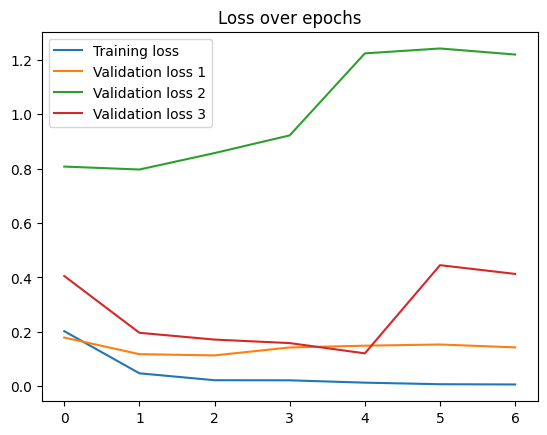

In [37]:
#run training loop for "S"
model_S = training_loop(train_dataloader_S, val_dataloader_sources_S, val_dataloader_morebetter_S, val_dataloader_generic_S,class_weights_S)

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.534716   |     -      |     -     |   1.78   
   1    |   40    |   0.482415   |     -      |     -     |   3.46   
   1    |   60    |   0.440018   |     -      |     -     |   5.15   
   1    |   80    |   0.416385   |     -      |     -     |   6.85   
   1    |   100   |   0.394592   |     -      |     -     |   8.55   
   1    |   120   |   0.377332   |     -      |     -     |   10.24  
   1    |   139   |   0.359850   |     -      |     -     |   11.81  
----------------------------------------------------------------------
 Epoch  | Dataset |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    | Sources |   0.361113   |  0.541474  |   72.24   |   12.75  
   1    |   MB    |   0.361113   |  1.476663  |   14.58   |   13.12  
   1    | Generic

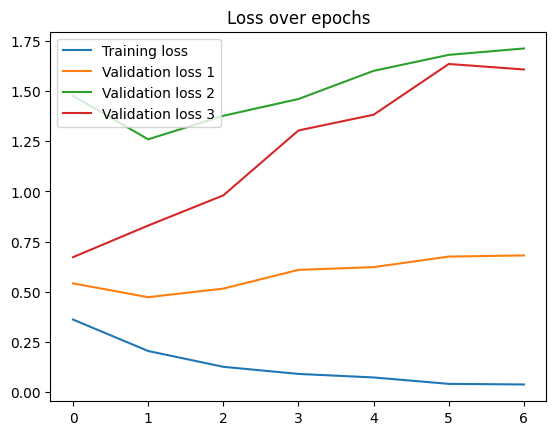

In [38]:
#run training loop for "O"
model_O = training_loop(train_dataloader_O, val_dataloader_sources_O, val_dataloader_morebetter_O, val_dataloader_generic_O, class_weights_O)

In [39]:
#torch.save(model_P, "model_O.pt")
#torch.save(model_L, "model_O.pt")
#torch.save(model_S, "model_O.pt")
#torch.save(model_O, "model_O.pt")

In [40]:
#tokenizer.save_pretrained('my_tokenizer/')

In [41]:
# TODO: save models and test dataloaders and bring to new notebook, with everything past this point

In [42]:
#TODO make function for evaluation on test set - this is a separate notebook
#to save test_dataloader to use in separate notebook:
#torch.save(dataloader_obj, 'dataloader.pth')
#torch.load

In [43]:
def apply_model_to_data_set(model, dataloader):
    model.eval()
    model=model.to(device)
    all_logits = []
    all_labels = []
    # For each batch in our test set...
    for sents, masks, texts, labels in dataloader:
        sents, masks = sents.to(device), masks.to(device)
        # Compute logits
        with torch.no_grad():
            logits = model(sents, masks)
            all_logits.append(logits)
            all_labels.append(labels)
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim = 0).cpu().numpy()
    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    preds = torch.argmax(all_logits, dim=1).flatten().cpu().numpy()
    all_logits = all_logits.cpu().numpy()
    return all_logits, all_labels, probs, preds

## Make calibration curves and calculate estimate for L in sources

In [44]:
(all_logits_test, all_labels_test, probs_test, preds_test) = apply_model_to_data_set(model_L, test_dataloader_sources_L)
(all_logits_val, all_labels_val, probs_val, preds_val) = apply_model_to_data_set(model_L, val_dataloader_sources_L)

(array([126.,   0.,   1.,   2.,   0.,   2.,   1.,   0.,   1.,   0.,   2.,
          0.,   1.,   1.,   2.,   1.,   2.,   6.,   0., 431.]),
 array([0.00429342, 0.05391894, 0.10354446, 0.15316997, 0.20279549,
        0.25242099, 0.30204651, 0.35167202, 0.40129754, 0.45092306,
        0.5005486 , 0.55017412, 0.59979963, 0.64942515, 0.69905066,
        0.74867618, 0.7983017 , 0.84792721, 0.89755273, 0.94717824,
        0.99680376]),
 <BarContainer object of 20 artists>)

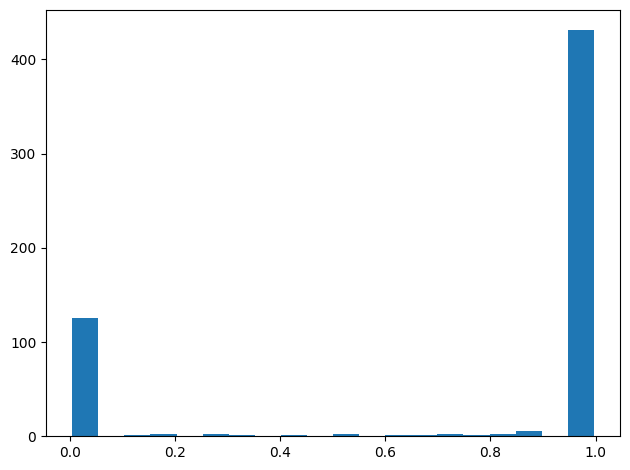

In [45]:
# Set up plots and view distribution of C(x)
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
df_val = pd.DataFrame(data = {"probs": probs_val[:,1], "gt_label":all_labels_val, "text":list(val_dataset_sources_L.texts.values)})
axs.hist(df_val["probs"], bins = 20)

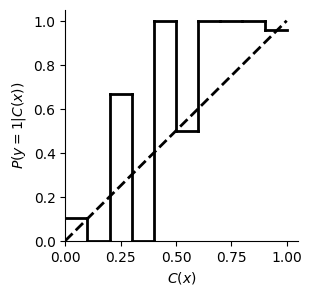

In [46]:
# Get binned calibration curve from validation set
binned_cal_curve = cal.generate_calibration_curve_binned(df_val, num_bin = 10, binary = True)
binned_cal_curve.plot(show_diagonal=True, filled = False)

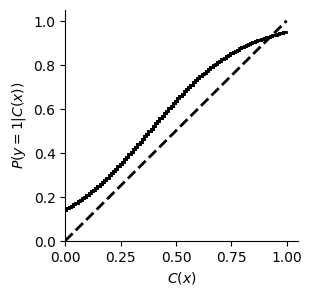

In [69]:
# Get platt calibration curve from validation set
platt_cal_curve = cal.generate_calibration_curve_platt(df_val, binary = True)
platt_cal_curve.plot(show_diagonal=True, filled = False)
plt.savefig("cal_curve.png", bbox_inches='tight')
plt.savefig("cal_curve.pdf", bbox_inches='tight')

In [48]:
# Use the calibration curve from validation set to estimate prevalence in test set
df_test = pd.DataFrame(data = {"probs": probs_test[:,1], "text":list(test_dataset_sources_L.texts.values)})
est_prevalence = cal.extrinsic_estimate(df_test, platt_cal_curve, code = "L")
print(f'Assuming stable calibration curve -- estimated prevalence: {est_prevalence:.3f}')

Assuming stable calibration curve -- estimated prevalence: 0.759


In [49]:
# Compare estimated prevalence to real prevalence
print(np.mean(all_labels_test))
print(np.mean(preds_test))

0.7616580310880829
0.7633851468048359


In [50]:
## View calibration curves from test set (just for fun)
#df_test = pd.DataFrame(data = {"probs": probs_test[:,1], "gt_label":all_labels_test, "text":list(test_dataset_sources_L.texts.values)})
#binned_cal_curve = cal.generate_calibration_curve_binned(df_test, num_bin = 10, binary = True)
#binned_cal_curve.plot(show_diagonal=True, filled = False)

In [51]:
#platt_cal_curve = cal.generate_calibration_curve_platt(df_test, binary = True)
#platt_cal_curve.plot(show_diagonal=True, filled = False)

## Compute performance results

In [55]:
# calculate metrics

#acc = accuracy_score(all_labels, preds)
#bal = balanced_accuracy_score(all_labels,preds)
#auc = roc_auc_score(all_labels,probs[:,1])


In [53]:
(all_logits_P, all_labels_P, probs_P, preds_P) = apply_model_to_data_set(model_P, test_dataloader_sources_P)
(all_logits_L, all_labels_L, probs_L, preds_L) = apply_model_to_data_set(model_L, test_dataloader_sources_L)
(all_logits_S, all_labels_S, probs_S, preds_S) = apply_model_to_data_set(model_S, test_dataloader_sources_S)
(all_logits_O, all_labels_O, probs_O, preds_O) = apply_model_to_data_set(model_O, test_dataloader_sources_O)

In [61]:
sources_performance = pd.DataFrame({"Code":["P","L","S","O"], 
                                        "labels":[all_labels_P,all_labels_L,all_labels_S,all_labels_O],
                                        "preds":[preds_P,preds_L,preds_S,preds_O],
                                        "probs":[probs_P[:,1],probs_L[:,1],probs_S[:,1],probs_O[:,1]]
                                       })

sources_performance["Accuracy"] = sources_performance.apply(lambda row: accuracy_score(row["labels"],row["preds"]), axis = 1)
sources_performance["Balanced accuracy"] = sources_performance.apply(lambda row: balanced_accuracy_score(row["labels"],row["preds"]), axis = 1)
sources_performance["AUC"] = sources_performance.apply(lambda row: roc_auc_score(row["labels"],row["probs"]), axis = 1)
sources_performance = sources_performance.drop(["labels","preds","probs"], axis = 1)

In [72]:
sources_performance.round(2)

,Code,Accuracy,Balanced accuracy,AUC
0,P,0.97,0.88,0.98
1,L,0.93,0.90,0.97
2,S,0.98,0.89,0.95
3,O,0.92,0.84,0.92


In [63]:
(all_logits_P, all_labels_P, probs_P, preds_P) = apply_model_to_data_set(model_P, test_dataloader_morebetter_P)
(all_logits_L, all_labels_L, probs_L, preds_L) = apply_model_to_data_set(model_L, test_dataloader_morebetter_L)
(all_logits_S, all_labels_S, probs_S, preds_S) = apply_model_to_data_set(model_S, test_dataloader_morebetter_S)
(all_logits_O, all_labels_O, probs_O, preds_O) = apply_model_to_data_set(model_O, test_dataloader_morebetter_O)

In [64]:
morebetter_performance = pd.DataFrame({"Code":["P","L","S","O"], 
                                        "labels":[all_labels_P,all_labels_L,all_labels_S,all_labels_O],
                                        "preds":[preds_P,preds_L,preds_S,preds_O],
                                        "probs":[probs_P[:,1],probs_L[:,1],probs_S[:,1],probs_O[:,1]]
                                       })

morebetter_performance["Accuracy"] = morebetter_performance.apply(lambda row: accuracy_score(row["labels"],row["preds"]), axis = 1)
morebetter_performance["Balanced accuracy"] = morebetter_performance.apply(lambda row: balanced_accuracy_score(row["labels"],row["preds"]), axis = 1)
morebetter_performance["AUC"] = morebetter_performance.apply(lambda row: roc_auc_score(row["labels"],row["probs"]), axis = 1)
morebetter_performance = morebetter_performance.drop(["labels","preds","probs"], axis = 1)

In [71]:
morebetter_performance.round(2)

,Code,Accuracy,Balanced accuracy,AUC
0,P,0.92,0.68,0.79
1,L,0.84,0.84,0.91
2,S,0.80,0.77,0.85
3,O,0.79,0.59,0.54


In [66]:
(all_logits_P, all_labels_P, probs_P, preds_P) = apply_model_to_data_set(model_P, test_dataloader_generic_P)
(all_logits_L, all_labels_L, probs_L, preds_L) = apply_model_to_data_set(model_L, test_dataloader_generic_L)
(all_logits_S, all_labels_S, probs_S, preds_S) = apply_model_to_data_set(model_S, test_dataloader_generic_S)
(all_logits_O, all_labels_O, probs_O, preds_O) = apply_model_to_data_set(model_O, test_dataloader_generic_O)

In [67]:
generic_performance = pd.DataFrame({"Code":["P","L","S","O"], 
                                        "labels":[all_labels_P,all_labels_L,all_labels_S,all_labels_O],
                                        "preds":[preds_P,preds_L,preds_S,preds_O],
                                        "probs":[probs_P[:,1],probs_L[:,1],probs_S[:,1],probs_O[:,1]]
                                       })

generic_performance["Accuracy"] = generic_performance.apply(lambda row: accuracy_score(row["labels"],row["preds"]), axis = 1)
generic_performance["Balanced accuracy"] = generic_performance.apply(lambda row: balanced_accuracy_score(row["labels"],row["preds"]), axis = 1)
generic_performance["AUC"] = generic_performance.apply(lambda row: roc_auc_score(row["labels"],row["probs"]), axis = 1)
generic_performance = generic_performance.drop(["labels","preds","probs"], axis = 1)

In [70]:
generic_performance.round(2)

,Code,Accuracy,Balanced accuracy,AUC
0,P,0.93,0.93,0.98
1,L,0.79,0.79,0.91
2,S,0.98,0.50,0.64
3,O,0.74,0.74,0.77
